In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
print("sklearn version: ", sklearn.__version__)
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
print("TF version: ", tf.__version__)
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# GPU test
print("GPU installed: ",tf.test.is_built_with_gpu_support())

# To prevent "CUDNN_STATUS_ALLOC_FAILED" error with GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)
    
# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "cnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    
# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")   

sklearn version:  0.24.2
TF version:  2.6.2
No GPU was detected. CNNs can be very slow without a GPU.
GPU installed:  True


In [2]:
import tensorflow as tf
from tensorflow import keras

In [4]:
# file이 있는 path로 이동
os.chdir("./emnist")
# os.chdir('/content/drive/MyDrive/ANN/') 

In [6]:
# Load EMNIST dataset
import pandas as pd
# import gzip

byclass_train = pd.read_csv("./emnist-byclass-train.csv")
byclass_test = pd.read_csv("./emnist-byclass-test.csv")
mapp = pd.read_csv("./emnist-byclass-mapping.txt", 
                   delimiter = ' ', index_col=0, header=None, squeeze=True)

In [7]:
# DataFrame
byclass_train.shape

(697931, 785)

In [8]:
byclass_train.head()

,35,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,...,0.466,0.467,0.468,0.469,0.470,0.471,0.472,0.473,0.474,0.475
0,36,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,22,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,38,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
byclass_test.shape

(116322, 785)

In [10]:
byclass_test.head()

,18,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,...,0.652,0.653,0.654,0.655,0.656,0.657,0.658,0.659,0.660,0.661
0,36,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,33,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,30,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
classes = len(byclass_train['35'].value_counts())
print('number of classes: ', classes)

number of classes:  62


In [12]:
# label만 뽑아내기
y_train_full = byclass_train[['35']]

# data만 뽑아내기
X_train_full = byclass_train.drop(['35'], axis=1)

In [13]:
# test에 대해서 반복
y_test = byclass_test[['18']]
X_test = byclass_test.drop(['18'], axis=1)

In [14]:
# pandas DF를 numpy로 바꿔주기
X_train_full, y_train_full = X_train_full.to_numpy(), y_train_full.to_numpy()
X_test, y_test = X_test.to_numpy(), y_test.to_numpy()

In [15]:
# Normalise data
X_train_full = X_train_full/255.
X_test = X_test/255.

In [16]:
X_train_full.astype('float32')
X_test.astype('float32')

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [17]:
# Reshape image for CNN
X_train_full = X_train_full.reshape(-1, 28, 28, 1)

X_test = X_test.reshape(-1, 28, 28, 1)

print("X_train.shape:", X_train_full.shape)
print("X_test.shape:", X_test.shape)

X_train.shape: (697931, 28, 28, 1)
X_test.shape: (116322, 28, 28, 1)


In [18]:
from tensorflow.keras import utils
from tensorflow.keras.utils import to_categorical

print('number of classes: ', classes)

# One hot encoding
y_train_full = to_categorical(y_train_full, classes)
y_test = to_categorical(y_test, classes)
print("y_train: ", y_train_full.shape)
print("y_test: ", y_test.shape)

number of classes:  62
y_train:  (697931, 62)
y_test:  (116322, 62)


In [19]:
# generate train and valid dataset
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=321)

In [20]:
# Print shape and datatype of X_rain_full

print(X_train.shape, X_train.dtype)
print(y_train.shape, y_train.dtype)

(558344, 28, 28, 1) float64
(558344, 62) float32


# Modeling-dense

In [21]:
# 무슨 모델 쓸~까요
""" 시현: ResNet
	병민: 파밍중
	다경: VGG
	재훈: inceptionNet(구글넷)"""


' 시현: ResNet\n\t병민: 파밍중\n\t다경: VGG\n\t재훈: inceptionNet(구글넷)'

In [22]:
import keras
from keras.models import Model
from keras.layers import Input, GlobalAveragePooling2D, Dense, concatenate, AveragePooling2D
from keras.layers.convolutional import Conv2D
from keras.layers.core import Activation, Dropout
from keras.layers import BatchNormalization
import numpy as np

# DenseNet
tf.random.set_seed(42)
np.random.seed(42)

In [23]:
class DenseNet:
    def __init__(self, input_shape=None, dense_blocks=3, dense_layers=-1, growth_rate=12, nb_classes=None,
                 dropout_rate=None, bottleneck=False, compression=1.0, weight_decay=1e-4, depth=40):

        # Checks
        if nb_classes == None:
            raise Exception(
                'Please define number of classes (e.g. num_classes=10). This is required for final softmax.')

        if compression <= 0.0 or compression > 1.0:
            raise Exception('Compression have to be a value between 0.0 and 1.0.')

        if type(dense_layers) is list:
            if len(dense_layers) != dense_blocks:
                raise AssertionError('Number of dense blocks have to be same length to specified layers')
        elif dense_layers == -1:
            dense_layers = int((depth - 4) / 3)
            if bottleneck:
                dense_layers = int(dense_layers / 2)
            dense_layers = [dense_layers for _ in range(dense_blocks)]
        else:
            dense_layers = [dense_layers for _ in range(dense_blocks)]

        self.dense_blocks = dense_blocks
        self.dense_layers = dense_layers
        self.input_shape = input_shape
        self.growth_rate = growth_rate
        self.weight_decay = weight_decay
        self.dropout_rate = dropout_rate
        self.bottleneck = bottleneck
        self.compression = compression
        self.nb_classes = nb_classes
        
    def build_model(self):
        img_input = Input(shape=self.input_shape, name='img_input')
        nb_channels = self.growth_rate
        
        x = Conv2D(2*self.growth_rate, (3,3), 
                   padding='same', strides = (1,1), 
                   kernel_regularizer=keras.regularizers.l2(self.weight_decay))(img_input)
        
        for block in range(self.dense_blocks-1):
            x, nb_channels = self.dense_block(x, self.dense_layers[block], nb_channels, self.growth_rate,
                                              self.dropout_rate, self.bottleneck, self.weight_decay)
            
            x = self.transition_layer(x, nb_channels, self.dropout_rate, self.compression, self.weight_decay)
            nb_channels = int(nb_channels*self.compression)
            
        x, nb_channels = self.dense_block(x, self.dense_layers[-1], nb_channels, self.growth_rate, self.dropout_rate, self.weight_decay)
        
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = GlobalAveragePooling2D()(x)
        prediction = Dense(self.nb_classes, activation='softmax')(x)
        
        return Model(inputs=img_input, outputs=prediction, name='densenet')
        
    def dense_block(self, x, nb_layers, nb_channels, growth_rate, dropout_rate=None, bottleneck=False, weight_decay=1e-4):
        for i in range(nb_layers):
            cb = self.convolution_block(x, growth_rate, dropout_rate, bottleneck)
            nb_channels += growth_rate
            x = concatenate([cb,x])
            
        return x, nb_channels
    
    def convolution_block(self, x, nb_channels, dropout_rate=None, bottleneck=False, weight_decay=1e-4):       

        # Bottleneck
        if bottleneck:
            bottleneckWidth = 4
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            x = Conv2D(nb_channels * bottleneckWidth, (1, 1),
                                     kernel_regularizer=keras.regularizers.l2(weight_decay))(x)
            # Dropout
            if dropout_rate:
                x = Dropout(dropout_rate)(x)

        # Standard (BN-ReLU-Conv)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Conv2D(nb_channels, (3, 3), padding='same')(x)

        # Dropout
        if dropout_rate:
            x = Dropout(dropout_rate)(x)

        return x

    def transition_layer(self, x, nb_channels, dropout_rate=None, compression=1.0, weight_decay=1e-4):
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Conv2D(int(nb_channels * compression), (1, 1), padding='same',
                                 kernel_regularizer=keras.regularizers.l2(weight_decay))(x)

        # Adding dropout
        if dropout_rate:
            x = Dropout(dropout_rate)(x)

        x = AveragePooling2D((2, 2), strides=(2, 2))(x)
        return x

In [24]:
densenet = DenseNet((28,28,1), nb_classes=62, depth=25)

In [25]:
model = densenet.build_model()

In [26]:
model.summary()

Model: "densenet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img_input (InputLayer)          [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 28, 28, 24)   240         img_input[0][0]                  
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 28, 28, 24)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 28, 28, 24)   0           batch_normalization[0][0]        
___________________________________________________________________________________________

In [27]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping

# checkpoint
filepath="model_val_loss.best.hdf5"
checkpoint_acc = ModelCheckpoint(filepath, monitor='acc', verbose=1, save_best_only=True, mode='auto')
# Early Stopping
earlyStopping_acc = EarlyStopping(monitor='acc', min_delta=0.01, patience=3, verbose=1, mode='auto', baseline=None, restore_best_weights=True)

callbacks_list = [checkpoint_acc, earlyStopping_acc]

In [28]:
# model_optimizer = Adam(lr=1E-3, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model_optimizer = tf.keras.optimizers.Adam()

In [29]:
model.compile(loss='categorical_crossentropy', optimizer=model_optimizer, metrics=["accuracy"])

In [30]:
history = model.fit(X_train, y_train, 
                    batch_size=64, epochs=10, 
                    validation_data=(X_valid, y_valid),
                    callbacks=callbacks_list)
score = model.evaluate(X_test, y_test)
print('\nTest Accuracy:', score)

Epoch 1/10
8725/8725 [==============================] - 7524s 862ms/step - loss: 0.5463 - accuracy: 0.8320 - val_loss: 0.4365 - val_accuracy: 0.8553
Epoch 2/10
8725/8725 [==============================] - 7514s 861ms/step - loss: 0.4151 - accuracy: 0.8582 - val_loss: 0.4190 - val_accuracy: 0.8570
Epoch 3/10
8725/8725 [==============================] - 7514s 861ms/step - loss: 0.3910 - accuracy: 0.8646 - val_loss: 0.4388 - val_accuracy: 0.8500
Epoch 4/10
8725/8725 [==============================] - 7513s 861ms/step - loss: 0.3768 - accuracy: 0.8680 - val_loss: 0.3973 - val_accuracy: 0.8581
Epoch 5/10
8725/8725 [==============================] - 7457s 855ms/step - loss: 0.3672 - accuracy: 0.8708 - val_loss: 0.3806 - val_accuracy: 0.8672
Epoch 6/10
8725/8725 [==============================] - 7496s 859ms/step - loss: 0.3603 - accuracy: 0.8723 - val_loss: 0.3597 - val_accuracy: 0.8730
Epoch 7/10
8725/8725 [==============================] - 8236s 944ms/step - loss: 0.3545 - accuracy: 0.8736

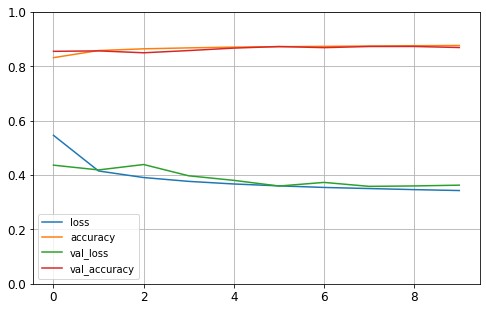

In [31]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

# Visualize model

In [32]:
# model1.summary()